# Computing the effect of a cost of dissipation in the fitness function

#### Importing modules

In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import palettable as pal
import itertools
import random

import copy
from tqdm import tqdm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import ScalarFormatter
from scipy import linalg as LA

In [2]:
import seaborn as sns
%matplotlib inline
sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":20})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

In [3]:
from physics import *
from network import *
from tools import save_vars
from evolution import *

## Curves at different dissipation costs

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|3| $10^{-3}$| $10^3$| 0.4| 7| 0.2|

In [11]:
N = 3       #  Size of the network
delta = 0.4
init = 0      # Definition of the initial state
size = 7
dsize = 0.2
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-7.00000000e+00 -6.80000000e+00 -6.60000000e+00 -6.40000000e+00
 -6.20000000e+00 -6.00000000e+00 -5.80000000e+00 -5.60000000e+00
 -5.40000000e+00 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00
 -4.60000000e+00 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00
 -3.80000000e+00 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00
 -3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  6.21724894e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00  3.00000000e+00  3.20000000e+00
  3.40000000e+00  3.60000000e+00  3.80000000e+00  4.00000000e+00
  4.20000000e+00  4.40000000e+00  4.60000000e+00  4.80000000e+00] Length: 60
Error

In [12]:
n_samples = 5

T = 1e-3  # Evolution temperature
t_s = [1e3]
mcsteps = 10000
track_e, track_S, track_t, track_ea, track_Sa, track_ta, = [ [] for i in range(6)]

for t_stall in t_s:
    

    #q_list = [5e3, 1e3, 1e2, 0.5, 0]
    q_list = [5e3, 1e3, 0]
    track_q = []
    for q in q_list:
        print('First search', q, 'T_stall', t_stall)
        track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
        track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                      size, dsize, maxsize)

        track_e.append(track_error_s)
        track_S.append(track_ent_s)
        track_t.append(track_time_s)

    track_ea.append(track_e)
    track_Sa.append(track_S)
    track_ta.append(track_t)

First search 5000.0 T_stall 1000.0
First search 1000.0 T_stall 1000.0
First search 0 T_stall 1000.0


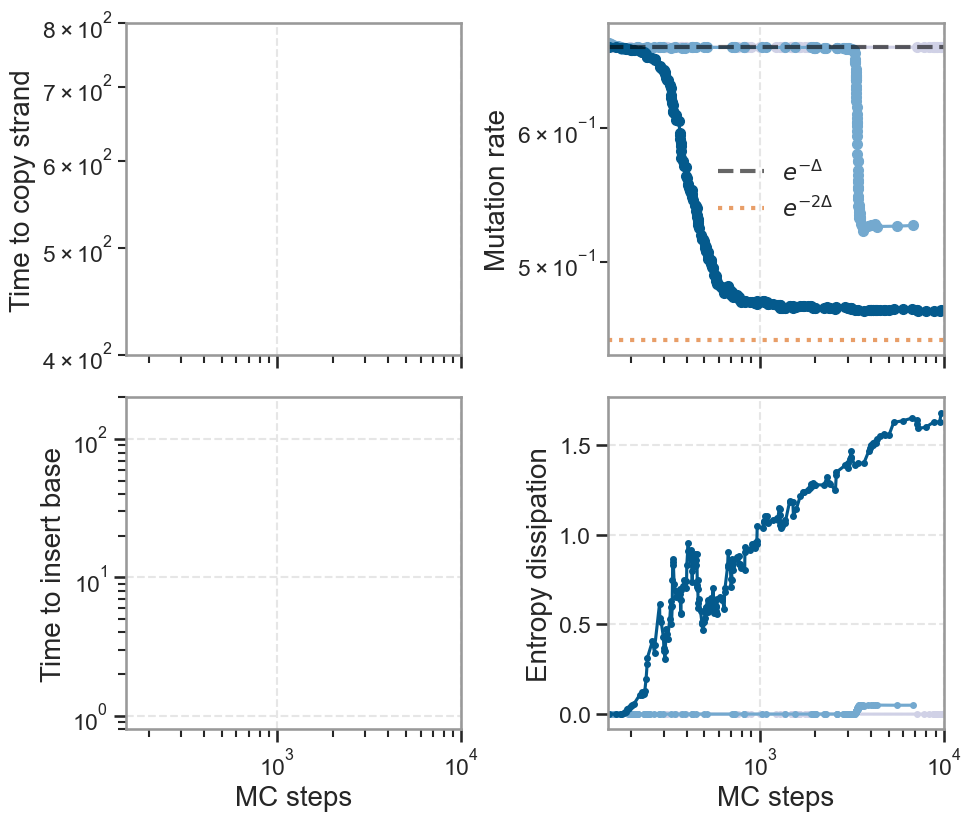

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10, 8.5), sharex=True)

for idx in range(1):
    time = np.asarray(track_t[idx][0])+1

    # Largest cost to entropy production
    idx_q = 0
    idx_sample = 3
    axs[1,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_S[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[1], markersize=4)

    axs[0,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_e[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[1], markersize=7)

    # Medium cost to entropy production
    idx_q = 1
    idx_sample = 3 # Change the idx_sample to find a sensible trajectory, this value of cost
                   # is right at the crossover between allowing or not for error correction
    axs[1,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_S[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[3], markersize=4)

    axs[0,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_e[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[3], markersize=7)

    # No cost to entropy production
    idx_q = 2
    idx_sample = 1 # Change this idx_sample as well if the trajectory does not show error correction
    axs[1,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_S[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[5], markersize=4)

    axs[0,1].plot(np.asarray(track_t[idx_q][idx_sample])+1, track_e[idx_q][idx_sample], '-o', \
                  color=pal.colorbrewer.sequential.PuBu_6.mpl_colors[5], markersize=7)


axs[0,0].set_ylabel('Time to copy strand')
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')

#axs[0,0].set_ylim([2e3,1e4])
axs[0,0].set_xlim([1.5e2,1e4])
axs[0,0].set_ylim([4e2,8e2])


axs[0,1].set_ylabel(r'Mutation rate')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
xlim = axs[0,0].get_xlim()
axs[0,1].plot(xlim, [np.exp(-delta), np.exp(-delta)], '--', color = 'black', linewidth=3, alpha=0.6, label=r'$e^{-\Delta}$')
axs[0,1].plot(xlim, [np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ':', color=(0.85, 0.37, 0.01), linewidth=3, \
              alpha=0.6, label=r'$e^{-%d\Delta}$'%((N-int(N/2))))
# axs[0,1].set_xlim([1e1,1e3])
axs[0,1].legend(frameon=False)

axs[1,1].set_ylabel("Entropy dissipation")
axs[1,1].set_xlabel('MC steps')
axs[1,1].set_xscale('log')
#axs[1,1].set_yscale('log')


axs[1,0].set_ylabel('Time to insert base')
axs[1,0].set_xlabel('MC steps')
axs[1,0].set_yscale('log')
axs[1,0].set_xscale('log')
axs[1,0].set_ylim([0.8e0,2e2])


fig.tight_layout()
plt.savefig('dissipation_curves_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T) )
plt.show()

### Crossover cost as function of stalling time

**Simulation is time-costly, load the data saved in the following**

For different values of stalling time, we swipe through different strength of dissipation cost to identify the value at which discrimination (or dissipation) starts to occur.

In [16]:
N = 3       #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 7
dsize = 0.2
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-7.00000000e+00 -6.80000000e+00 -6.60000000e+00 -6.40000000e+00
 -6.20000000e+00 -6.00000000e+00 -5.80000000e+00 -5.60000000e+00
 -5.40000000e+00 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00
 -4.60000000e+00 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00
 -3.80000000e+00 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00
 -3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  6.21724894e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00  3.00000000e+00  3.20000000e+00
  3.40000000e+00  3.60000000e+00  3.80000000e+00  4.00000000e+00
  4.20000000e+00  4.40000000e+00  4.60000000e+00  4.80000000e+00] Length: 60
Error

### Decrease in error rate as criterion

The code below can be used to calculate the crossover with error rate as criterion. It takes some time to run since it explores different samples and stalling times, the trajectories used are saved and can be loaded.

In [ ]:
n_samples = 5
n_cycles = 6
mcsteps = 5000
percent = 0.5
T = 1e-3  # Evolution temperature

#t_s = [5e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 1e6]
t_s = [5e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4]
track_e, track_S, cost, stalling = [ [] for i in range(4)]


for t_stall in t_s:
    
    q_list = [1e5, 1e4, 1e3, 1e2, 1e1, 0]
    track_q = []
    for q in q_list:
        print('First search', q, 'T_stall', t_stall)
        track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
        track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                      size, dsize, maxsize)

        track_e.append(track_error_s)
        track_S.append(track_ent_s)

        error_drop = []
        for s in range(n_samples):
            tmp =  np.asarray(track_error_s[s])[0] - np.asarray(track_error_s[s])[-1]
            error_drop.append(tmp)

        threshold = percent*(np.exp(-delta) - np.exp(-(N-int(N/2))*delta))
        if any(y > threshold for y in error_drop):
            print("Cost: ", q, 'T_stall', t_stall)
            track_q.append(q)
            break

    for cycles in range(n_cycles):
        if track_q[-1] != 0:
            kk = [6, 5, 4, 3, 2, 1, -1]
        if track_q[-1] == 0:
            kk = [6, 5, 4, 3, 2, 1, 0.1]
        if (cycles==1)*(track_q[-1] < 1e1):
            break
            
        a = []
        for k in range(len(kk)):
            if track_q[-1] != 0:
                a.append( track_q[-1] + kk[k]*0.1*track_q[-1] )
            if track_q[-1] == 0:
                a.append( track_q[-1] + kk[k] )
        print('New list of costs: ', a)

        for q in q_list:   
            print('Cycle %d search'%(cycles), q, 'T_stall', t_stall)

            track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
            track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                          size, dsize, maxsize)

            track_e.append(track_error_s)
            track_S.append(track_ent_s)

            # Quantifying the error drop
            error_drop = []
            for s in range(n_samples):
                tmp =  np.asarray(track_error_s[s])[0] - np.asarray(track_error_s[s])[-1]
                error_drop.append(tmp)

            threshold = percent*(np.exp(-delta) - np.exp(-(N-int(N/2))*delta))
            if any(y > threshold for y in error_drop):
                print("Cost: ", q, 'T_stall', t_stall)
                track_q.append(q)
                break
    cost.append(track_q[-1])
    stalling.append(t_stall)

In [ ]:
# import pickle
# trajs = [stalling, cost]
# with open('discrimination_cost_50p.pickle', 'wb') as handle:
#     pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL) 

#### Increase in entropy as criterion

The code below can be used to calculate the crossover with entropy production rate as criterion. It takes some time to run since it explores different samples and stalling times, the trajectories used are saved and can be loaded.

In [ ]:
n_samples = 5
n_cycles = 6
percent = 0.5
T = 1e-3  # Evolution temperature
#t_s = [5e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
t_s = [5e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4]
track_e, track_S, track_t, cost, stalling = [ [] for i in range(5)]

for t_stall in t_s:
    
    if t_stall > 1e3:
        mcsteps = int(5e3)
        threshold = 1e-4
    if (t_stall > 1e2)*(t_stall <= 1e3):
        mcsteps = int(1e4)
        threshold = 1.9e-2
    if t_stall < 3e2:
        mcsteps = int(1e4)
        #threshold = 2.5e-2
        threshold = 4e-2
    #q_list = [1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 0]
    q_list = [1e5, 1e4, 1e3, 1e2, 1e1, 0]
    track_q = []
    for q in q_list:
        print('First search', q, 'T_stall', t_stall)
        track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
        track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                      size, dsize, maxsize)

        track_e.append(track_error_s)
        track_S.append(track_ent_s)
        track_t.append(track_time_s)

        ent_hist = []
        for s in range(n_samples):
            #tmp =  np.asarray(track_ent_s[s])[-1]
            tmp =  np.mean(np.asarray(track_ent_s[s])[-5:])
            ent_hist.append(tmp)

        print(np.mean(ent_hist))
        if abs(np.mean(ent_hist)) > threshold:
            print("Entropy is more than: ", threshold, "Cost: ", q, 'T_stall', t_stall)
            track_q.append(q)
            break

    for cycles in range(n_cycles):
        if track_q[-1] != 0:
            kk = [6, 5, 4, 3, 2, 1, -1]
        if track_q[-1] == 0:
            kk = [6, 5, 4, 3, 2, 1, 0.1]
        if (cycles==1)*(track_q[-1] < 1e1):
            break
            
        q_list = []
        for k in range(len(kk)):
            if track_q[-1] != 0:
                q_list.append( track_q[-1] + kk[k]*0.1*track_q[-1] )
            if track_q[-1] == 0:
                q_list.append( track_q[-1] + kk[k] )
        print('New list of costs: ', q_list)

        for q in q_list:
            print('Cycle %d search'%(cycles), q, 'T_stall', t_stall)

            track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
            track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                          size, dsize, maxsize)

            track_e.append(track_error_s)
            track_S.append(track_ent_s)
            track_t.append(track_time_s)

            # Entropy increase
            ent_hist = []
            for s in range(n_samples):
                #tmp =  np.asarray(track_ent_s[s])[-1]
                tmp = np.mean(np.asarray(track_ent_s[s])[-5:])
                ent_hist.append(tmp)

            print(np.mean(ent_hist))
            if abs(np.mean(ent_hist)) > threshold:
                print("Entropy is more than: ", threshold, "Cost: ", q, 'T_stall', t_stall)
                track_q.append(q)
                break
    cost.append(track_q[-1])
    stalling.append(t_stall)

Saving the data

In [ ]:
# import pickle
# trajs = [stalling, cost]
# with open('entropy_cost_50p.pickle', 'wb') as handle:
#     pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL) 

Plotting the data

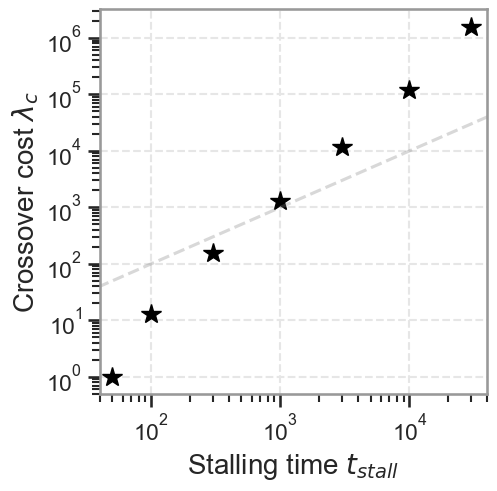

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
line = np.linspace(1e1, 1e5, 100)
ax.plot(stalling, cost, '*', color = 'black',markersize=15)
ax.plot(line, line, '--', color='gray', alpha=0.3)
ax.set_xlabel(r'Stalling time $t_{stall}$')
ax.set_ylabel(r'Crossover cost $\lambda_c$')
ax.set_xscale('log')
ax.set_xlim([4e1, 4e4])
ax.set_yscale('log')

#### Loading the data saved from the code above

In [22]:
import pickle
with open('kinetic-proofreading_data/discrimination_cost_50p.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

stalling_1 = trajs[0]
cost_1 = trajs[1]

with open('kinetic-proofreading_data/entropy_cost_50p.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

stalling = trajs[0]
cost = trajs[1]

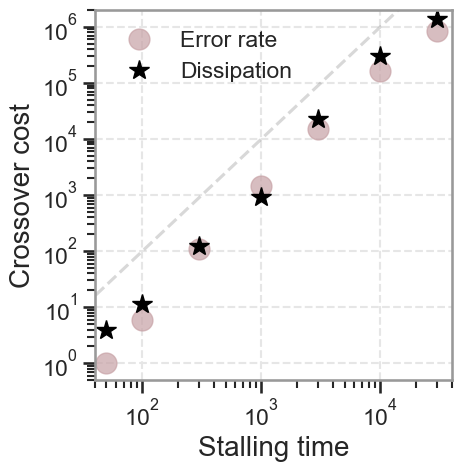

In [23]:
fig, ax = plt.subplots(figsize=(4.9, 5))
line = np.linspace(1e1, 1e5, 100)
ax.plot(stalling_1, cost_1, 'o', color = '#C7A2A6',markersize=15, alpha=0.7, label = r'Error rate')
ax.plot(stalling, cost, '*', color = 'black',markersize=15, label = r'Dissipation')
ax.plot(line, 0.01*line**2, '--', color='gray', alpha=0.3)
ax.set_xlabel('Stalling time')
ax.set_ylabel('Crossover cost')
ax.set_xscale('log')
ax.set_xlim([4e1, 4e4])
ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_ylim([0.5,2*1e6])
fig.tight_layout()
#plt.savefig('dissipation_cost_22.pdf')